# Processing

In [ ]:
import pandas as pd
import datetime
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
import seaborn as sns
import altair as alt
import random
import scipy.stats as stats
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 100000,"display.max_columns", 100)
pd.options.display.float_format = '{:,.0f}'.format
# !pip install dingsound
# import dingsound as d
%matplotlib inline

In [ ]:
!git clone 'https://github.com/sangtrankt98/njv_capacity.git'
# ! ls
# ! rm -rf '/content/njv_capacity'

Cloning into 'njv_capacity'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 136 (delta 55), reused 113 (delta 42), pack-reused 0
Receiving objects: 100% (136/136), 43.05 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (55/55), done.


Notes:
- FM only combine C2C pick up orders
- LM only combine orders deli, ignore RTS orders
- Dataframe: Dec 2020 - Aprl 2021

In [ ]:
lm= pd.read_csv('/content/njv_capacity/capacity calculation/lm_index.csv')
fm= pd.read_csv('/content/njv_capacity/capacity calculation/fm_index.csv')
rts= pd.read_csv('/content/njv_capacity/capacity calculation/rts_index.csv')
kpi= pd.read_csv('/content/njv_capacity/capacity calculation/kpi_index.csv')
driver= pd.read_csv('/content/njv_capacity/capacity calculation/driver_index.csv')
hub= pd.read_csv('/content/njv_capacity/capacity calculation/hub.csv')

In [ ]:
# +0.05*aggregated['succcess_day3_OTP']
aggregated1 = lm.merge(rts,how='left',on= ['cal_date','shipper_group','hub_id'])
aggregated2 = aggregated1.merge(fm,how='outer',on=['cal_date','shipper_group','hub_id'])
aggregated = aggregated2.merge(hub,how='inner',on=['hub_id'])
aggregated.fillna(value = 0,inplace=True)
aggregated['cal_date']=pd.to_datetime(aggregated['cal_date'],format='%Y-%m-%d')
aggregated['created_month']=pd.to_datetime(aggregated['created_month'],format='%Y-%m')
aggregated['area']=aggregated['hub_region'].map({'HN':'Metro','HCM': 'Metro', 'North':'Non-Metro','South': 'Non-Metro'})

In [ ]:
hub_info={
'hub_id':
[1235,191,1233,1239,963],
'hub_name_update':
['HCM - Phu Nhuan - SOU - DP','HCM - District 9 A - SOU - DP','HCM - Go Vap A - SOU - DP','HCM - Tan Binh 1 - SOU - DP','HCM - Can Gio 1 - SOU - DP'],
'hub_id_update':
[236,120,130,823,944]
}
for i in range(len(hub_info)+1):
  aggregated.loc[aggregated['hub_id']==hub_info['hub_id'][i],'hub_name']= hub_info['hub_name_update'][i]
  aggregated.loc[aggregated['hub_id']==hub_info['hub_id'][i],'hub_id']= hub_info['hub_id_update'][i]
  driver.loc[driver['hub_id']==hub_info['hub_id'][i],'hub_id']= hub_info['hub_id_update'][i]

# Calculation & Visulization

In [ ]:
# Driver performance mapping
driver_map=driver.merge(hub[['hub_id','hub_name','hub_region','hub_sector']],how='inner',on='hub_id')
driver_map=driver_map.groupby(['cal_date','hub_id','hub_region','hub_sector','hub_name']).agg({'rider_no':'sum','parcel_no':'sum'}).reset_index()
final_result=pd.DataFrame()
sl_rate=np.around(np.arange(start=0.8, stop=1, step=0.01,dtype=np.float64),2).tolist()
col_list=['first_pu_ontime_rate','pu_success_ontime_rate','first_deli_ontime_rate','deli_succcess_ontime_day1_rate','success_rate']
sl_rate1=[0.93]
sl_rate2=[0.94]
sl_rate3=[0.91]
for i in range(1):
  kpi.update(kpi.loc[kpi['hub_region']=='HCM'].replace(to_replace={col:sl_rate1 for col in col_list},value=sl_rate1[i]),overwrite=True)
  kpi.update(kpi.loc[kpi['hub_region']=='HN'].replace(to_replace={col:sl_rate1 for col in col_list},value=sl_rate2[i]),overwrite=True)
  kpi.update(kpi.loc[kpi['area']=='Non-Metro'].replace(to_replace={col:sl_rate for col in col_list},value=sl_rate3[i]),overwrite=True)
  calculation = aggregated.merge(kpi,how='left',on=['shipper_group','hub_region'],suffixes=('','_kpi'))
  calculation['total_volume']= calculation.apply(lambda row: row.fm_orders + row.lm_orders, axis=1)
  # Calculation the percentage of each shipper group
  percentage=calculation.groupby(['cal_date','hub_id','shipper_group']).agg({'total_volume':'sum'}).groupby(['cal_date','hub_id']).apply(lambda x: x/x.sum()).reset_index()
  percentage.sort_values(by=['cal_date','hub_id'],inplace= True)
  percentage.fillna(value = 0,inplace=True)
  percentage.columns=['cal_date', 'hub_id', 'shipper_group', 'total_volume_percentage']
  # percentage[percentage['total_volume'].isnull()]
  calculation=calculation.merge(percentage,how='left',on=['cal_date','shipper_group','hub_id'])
  # Calculate service level score
  calculation.fillna(value = 0,inplace=True)
  calculation['check6']=calculation['first_deli_ontime_rate'].ne(0).astype(int)
  calculation['check7']=calculation['deli_succcess_ontime_day1_rate'].ne(0).astype(int)
  calculation['check8']=calculation['first_pu_ontime_rate'].ne(0).astype(int)
  calculation['check9']=calculation['pu_success_ontime_rate'].ne(0).astype(int)
  calculation['check10']=calculation['success_rate'].ne(0).astype(int)
  calculation['actual_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate*x.check1 + x.deli_succcess_ontime_day1_rate*x.check2 + x.first_pu_ontime_rate*x.check3 + x.pu_success_ontime_rate*x.check4 + x.success_rate*x.check5)*x.total_volume_percentage , axis=1)
  calculation['kpi_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate_kpi*x.check6 + x.deli_succcess_ontime_day1_rate_kpi*x.check7 + x.first_pu_ontime_rate_kpi*x.check8 + x.pu_success_ontime_rate_kpi*x.check9 + x.success_rate_kpi*x.check10)*x.total_volume_percentage , axis=1)

  # prepare conditions
  pre_final=calculation[['cal_date','shipper_group','hub_name','hub_id','fm_orders','lm_orders','total_volume','actual_score','kpi_score']]
  pre_final = pre_final[pre_final['total_volume'].isnull()==False]
  # Filter 1: active day
  filter1 = pre_final.groupby(['hub_id']).agg({'cal_date':pd.Series.nunique}).reset_index()
  hub_low_time=filter1[filter1['cal_date']<=60]['hub_id'].to_list()
  pre_final=pre_final[(~pre_final['hub_id'].isin(hub_low_time))&(pre_final['cal_date']<=dt.datetime(2021,4,30))]
  # Filter 2: volume/day
  filter2 = pre_final.groupby(['hub_id']).agg({'total_volume':'mean'}).reset_index()
  hub_low_workload=filter2[filter2['total_volume']<=5]['hub_id'].to_list()
  pre_final=pre_final[~pre_final['hub_id'].isin(hub_low_workload)]
  #  Filter 3: remove low score
  final=pre_final.groupby(['cal_date','hub_id']).agg({'total_volume':'sum','actual_score':'sum','kpi_score':'sum'}).reset_index()
  final1=final
  final=final[final['actual_score']>=final['kpi_score']]
  # Remove outlier & calulate z-score
  final['z_score_total_volume']=final.groupby(['hub_id']).total_volume.transform(lambda x : stats.zscore(x,ddof=1))
  final['mean_total_volume']=final.groupby(['hub_id']).total_volume.transform(lambda x : x.mean())
  final['std_total_volume']=final.groupby(['hub_id']).total_volume.transform(lambda x : x.std(ddof=1))
  final['q1_z']=final.groupby(['hub_id']).z_score_total_volume.transform(lambda x : x.quantile(.25))
  final['q3_z']=final.groupby(['hub_id']).z_score_total_volume.transform(lambda x : x.quantile(.75))
  final['lower_z']=final.apply(lambda x: 2.5*x.q1_z-1.5*x.q3_z, axis=1)
  final['upper_z']=final.apply(lambda x: 2.5*x.q3_z-1.5*x.q1_z, axis=1)
  ## Filter
  final = final[(final['z_score_total_volume']>=final['lower_z'])&(final['z_score_total_volume']<=final['upper_z'])]
  observation = final[['hub_id','cal_date']].groupby(['hub_id']).agg('count').reset_index()
  observation.rename(columns={'cal_date': 'observation_num'},inplace=True)
  # Calculate confidence interval
  hub_id=list(final['hub_id'].unique())
  result= pd.DataFrame()
  for hub_id in hub_id:
    data=stats.bayes_mvs(final[final['hub_id']==hub_id]['total_volume'],alpha= 0.9)
    dict = {
    'hub_id':hub_id,
    'mean': [data[0][0]],
    'lower': [data[0][1][0]],
    'upper': [data[0][1][1]],
    'range': data[0][1][1]-data[0][1][0],
    'sl_rate': sl_rate1[i]
    }
    append = pd.DataFrame.from_dict(dict)
    result= result.append(append)
  result=result.merge(driver_map,how='left',on='hub_id')
  result=result.merge(observation,how='left',on='hub_id')
  pre_result = result[(result['parcel_no']<=result['upper'])&(result['parcel_no']>=result['lower'])].groupby(['hub_region','hub_sector','hub_id','hub_name','sl_rate','observation_num']).agg({'mean':'mean','lower':'mean','upper':'mean','range':'mean','rider_no':'mean'}).reset_index()
  final_result = final_result.append(pre_result)
# Calculation Utilization rate
volume_weekly=final1[['cal_date','total_volume','hub_id']].groupby([final1['cal_date'].dt.to_period('W-MON').dt.to_timestamp('W-MON'),'hub_id']).agg({'total_volume':'sum','cal_date':pd.Series.nunique}).rename(columns={'cal_date': 'working_days'}).reset_index()
util_cal=final_result.merge(volume_weekly,how='inner',on='hub_id')
util_cal['projection']=util_cal.apply(lambda x: x.upper*x.working_days,axis=1)
util_cal['util_rate']=util_cal.apply(lambda x: (x.total_volume/(x.upper*x.working_days))*100.00,axis=1)
util_cal['over_cap']=util_cal.apply(lambda x: True if x.total_volume >= x.projection else False,axis=1)
util_cal['under_cap']=util_cal.apply(lambda x: True if x.total_volume < x.projection else False,axis=1)
util_cal['range']=util_cal.apply(lambda x: x.total_volume - x.projection,axis=1)
util_cal=util_cal.round({'rider_no':0,'mean':0,'upper':0,'lower':0,'util_rate':2,'range':0}).reset_index(drop=True)
util_cal['cal_date']=util_cal['cal_date'].dt.strftime('%Y-%m-%d') 

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


[Text(0, 0, '1034 \n (n=17)'),
 Text(0, 0, '226 \n (n=94)'),
 Text(0, 0, '297 \n (n=51)'),
 Text(0, 0, '381 \n (n=71)'),
 Text(0, 0, '1192 \n (n=6)'),
 Text(0, 0, '251 \n (n=97)'),
 Text(0, 0, '518 \n (n=74)'),
 Text(0, 0, '1269 \n (n=30)'),
 Text(0, 0, '228 \n (n=74)'),
 Text(0, 0, '88 \n (n=110)')]

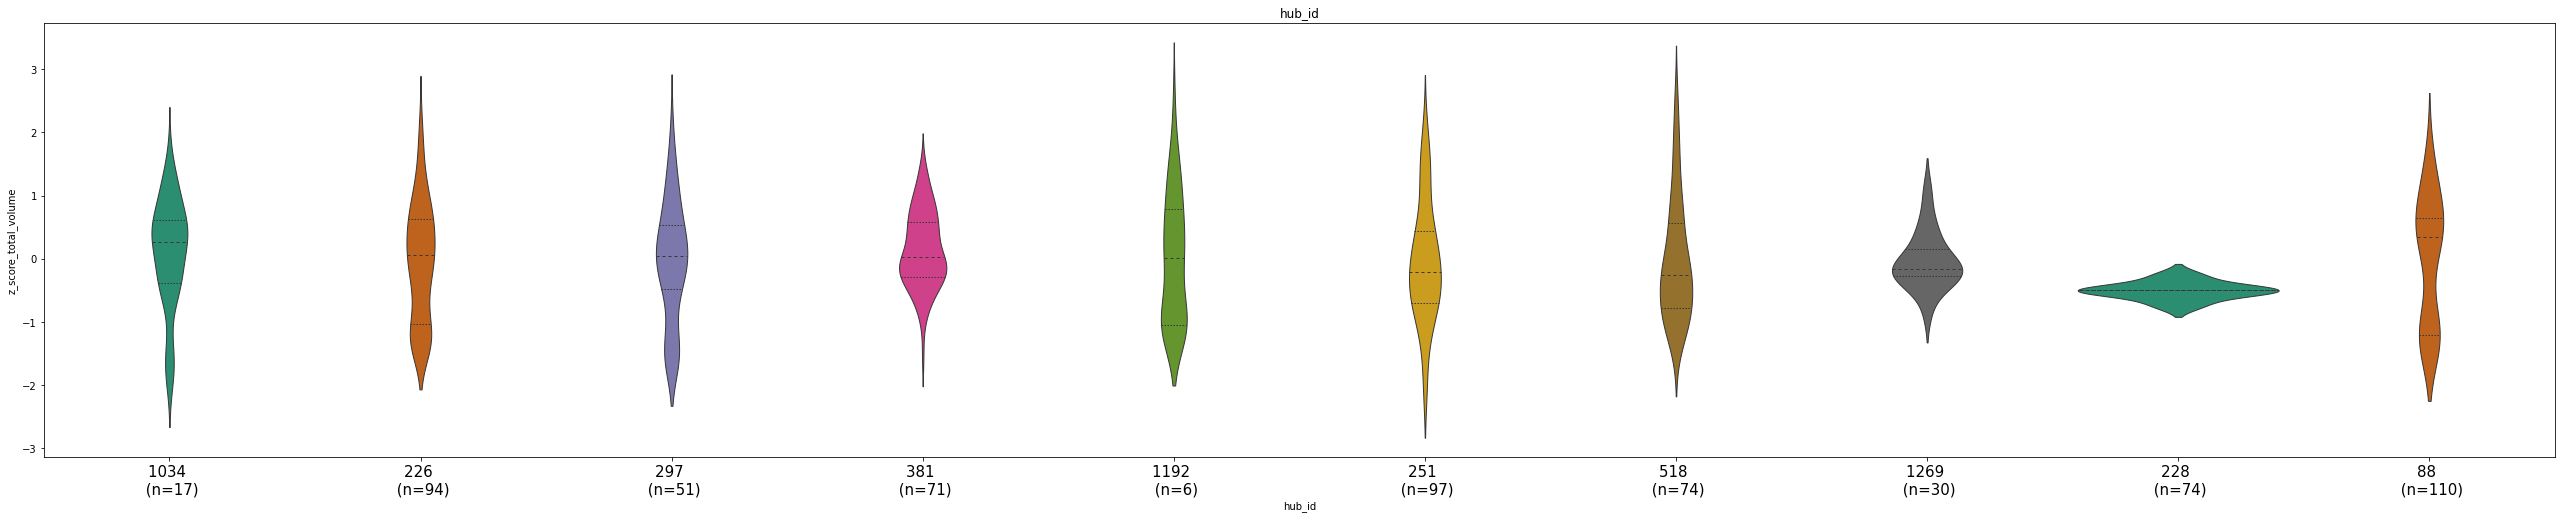

In [ ]:
hub_rand = random.sample(final['hub_id'].unique().tolist(),10)
fig, ax1 = plt.subplots(1,1,figsize=(45,8),squeeze =False)
sns.set_theme(style="whitegrid")
sns.violinplot(data=final[final['hub_id'].isin(hub_rand)],x='hub_id',y='z_score_total_volume',linewidth=1,inner="quartile",ax=ax1[0,0],palette='Dark2')
# sns.boxplot(data=df3,x='target',y='hub_region',ax=ax1[0,2],palette='Dark2')
ax1[0,0].set_title('hub_id')
xlabels = [f"{hub} \n (n={final[final['hub_id']==hub]['hub_id'].size})" for hub in hub_rand]
ax1[0,0].set_xticklabels(xlabels, size=15, ha="center", ma="center")

In [ ]:
for i in hub_rand:
  skew=stats.skew(final[final['hub_id']==i]['z_score_total_volume'], axis=0, bias=True)
  print(f'skewness of {i} is:\n{skew}')

skewness of 1034 is:
0.8840516490524596
skewness of 226 is:
0.13716724991966325
skewness of 297 is:
0.4604628555549228
skewness of 381 is:
0.2876322758093256
skewness of 1192 is:
0.0
skewness of 251 is:
0.1251703092785513
skewness of 518 is:
0.9294275438774857
skewness of 1269 is:
-0.18806308629040666
skewness of 228 is:
-0.07327763205421865
skewness of 88 is:
-0.711334979569673


Text(0, 0.5, 'Density')

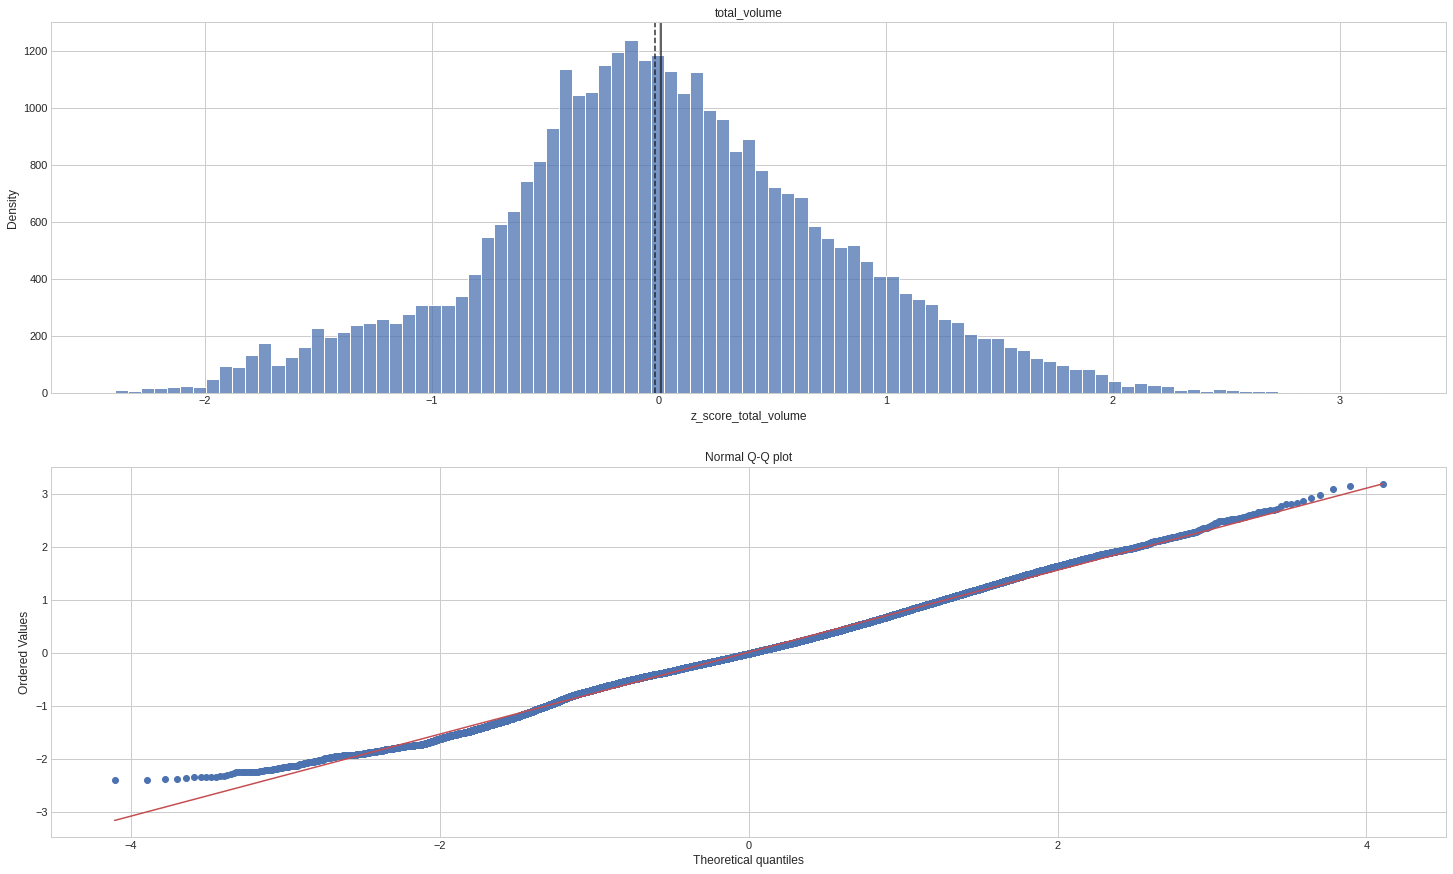

In [ ]:
# plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(25, 15))
sns.histplot(data=final,x=final['z_score_total_volume'],ax=ax[0])
# stats.probplot(final['z_score_total_volume'], dist=stats.loggamma, plot=ax[2])
ax[0].axvline(np.mean(final['z_score_total_volume']), color='k', label='Mean', linestyle='-', alpha=0.9)
ax[0].axvline(np.median(final['z_score_total_volume']), color='k', label='Median', linestyle='--', alpha=0.9)

stats.probplot(final['z_score_total_volume'], dist=stats.norm, plot=ax[1])

# Plot formatting
ax[1].set_title('Normal Q-Q plot')
ax[0].set_title('total_volume')
ax[0].set_xlabel('z_score_total_volume')
ax[0].set_ylabel('Density')

# Data Final

In [ ]:
final_result.to_csv('/content/drive/MyDrive/Capacity Project/hub_capacity.csv')

In [ ]:
final_result['productivity'] = final_result['mean']/final_result['rider_no']
final_result=final_result.round({'rider_no':0,'mean':0,'upper':0,'lower':0,'productivity':0}).reset_index(drop=True)
final_result[['hub_name','hub_id','mean','lower','upper','rider_no','productivity']].sort_values(by=['mean','upper'],ascending=True).head(12)

,hub_name,hub_id,mean,lower,upper,rider_no,productivity
454,LAD - Bao Lam - SOU - SUB 2,1259,0,-0,1,1,0
70,QUT - Vinh Linh - NOR - SUB 2,638,1,1,1,2,0
347,CAM - Dam Doi - SOU - SUB 2,771,2,2,3,1,2
396,QUA - Bac Tra My - SOU - SUB 2,431,3,0,5,1,3
411,DAN - Dak Glong - SOU - SUB 2,744,3,-1,6,1,3
246,LAC - Sin Ho Thap - NOR - SUB 2,1128,4,3,5,2,2
399,DAK - Buon Don - SOU - SUB 2,439,5,2,8,1,5
186,DIB - Dien Bien Dong - NOR - SUB 2,590,13,10,15,1,13
445,KHH - Binh Ba - SOU - SUB 2,1171,14,13,16,1,14
433,DAN - Tuy Duc - SOU - SUB 2,994,14,8,21,3,5


In [ ]:
final_result['productivity'] = final_result['mean']/final_result['rider_no']
final_result=final_result.round({'rider_no':0,'mean':0,'upper':0,'lower':0,'productivity':0}).reset_index(drop=True)
final_result[['hub_name','hub_id','mean','lower','upper','rider_no','productivity']].sort_values(by=['mean','upper'],ascending=False).head(12)

,hub_name,hub_id,mean,lower,upper,rider_no,productivity
250,HOB - Da Bac - NOR - SUB 2,1170,inf,-124,173,2,inf
5,HCM - Go Vap A - SOU - DP,130,"6,169","5,907","6,431",54,114
26,HN - Ha Dong - NOR - DP,216,"5,906","5,731","6,080",34,174
27,HN - Hoang Mai 1 - NOR - DP,222,"5,297","5,112","5,482",30,177
41,HN - Hoai Duc - NOR - SUB 2 - DP,859,"5,149","4,945","5,353",30,172
10,HCM - Tan Phu 1 - SOU - DP,199,"4,340","4,167","4,513",37,117
19,HCM - Tan Binh 1 - SOU - DP,823,"4,029","3,867","4,192",60,67
40,HN - Thanh Xuan 1 - NOR - DP,855,"3,923","3,742","4,103",31,127
28,HN - Bac Tu Liem - NOR - DP,259,"3,693","3,598","3,787",27,137
50,HN - Hoang Mai 2 - NOR - DP,1211,"3,648","3,498","3,798",27,135


In [ ]:
util_cal_check=util_cal.groupby(['hub_name','hub_id']).agg({'util_rate':'mean'}).reset_index()
util_cal_check.sort_values(by=['util_rate'],ascending=False).head(15)

,hub_name,hub_id,util_rate
271,LAD - Bao Lam - SOU - SUB 2,1259,5982.021111
74,CAM - Dam Doi - SOU - SUB 2,771,5445.295714
367,QUT - Vinh Linh - NOR - SUB 2,638,3511.284762
93,DAN - Dak Glong - SOU - SUB 2,744,1174.260000
340,QUA - Bac Tra My - SOU - SUB 2,431,694.856667
84,DAK - Buon Don - SOU - SUB 2,439,486.662667
348,QUA - Nui Thanh - SOU - SUB 2,411,417.029545
268,LAC - Sin Ho Thap - NOR - SUB 2,1128,288.267727
89,DAK - Ea Sup - SOU - SUB 2,916,254.763810
97,DAN - Tuy Duc - SOU - SUB 2,994,245.375455


In [ ]:
util_cal_check.sort_values(by=['util_rate'],ascending=True).head(15)

,hub_name,hub_id,util_rate
213,HOB - Da Bac - NOR - SUB 2,1170,27.410909
80,CT - Cai Rang - SOU - SUB 2,1274,41.943125
5,ANG - Tan Chau - SOU - SUB 2,1269,47.573000
35,BID - An Nhon - SOU - SUB 2,1261,61.014286
48,BIT - Da Mi - SOU - SUB 2,1212,61.536667
247,KIG - Tan Hiep - SOU - SUB 2,1272,62.416250
148,HAT - Ky Anh - NOR - SUB 2,606,63.598182
411,THH - Thuong Xuan - NOR - SUB 2,1024,64.757727
141,HAG - Yen Minh - NOR - SUB 2,1035,66.624091
403,THH - Muong Lat - NOR - SUB 2,1087,70.016364
